In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Paths and waveguides

[PHIDL](https://github.com/amccaugh/phidl) includes an extremely efficient module for creating smooth curves, particularly useful for creating waveguide structures such as those used in photonics.   There are two components to creating a path: (1) specify the points you want the path to follow, and (2) specify what you want the path cross-section to look like. Creating a path device is simple:

- Create a blank `Path`
- Append points to the `Path` either using the built-in functions (`arc`, `euler_bend`, `straight`) or by providing your own lists of points
- Specify what you want the cross-section (`Xsection`) to look like
- Combine the `Path` and the `Xsection` (will output a Device with the path polygons in it)

## Path creation

The first step is to generate the list of points we want the path to follow.  Let's start out by creating a blank `Path` and using the built-in functions to make a few turns.

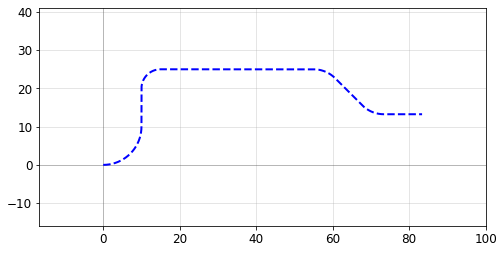

In [2]:
from phidl import Path, Xsection
import phidl.path as pp

P = Path()
P.append( pp.arc(radius = 10, angle = 90) )
P.append( pp.straight(length = 10) )
P.append( pp.arc(radius = 5, angle = -90) )
P.append( pp.straight(length = 40) )
P.append( pp.arc(radius = 8, angle = -45) )
P.append( pp.straight(length = 10) )
P.append( pp.arc(radius = 8, angle = 45) )
P.append( pp.straight(length = 10) )

from phidl import quickplot as qp
qp(P)

So far, all we've done is added points together.  If we examine our new path `P` we can see that all we've simply created long list of points:

In [3]:
import numpy as np
path_points = P.points       # Curve points are stored as a numpy array in P.points
print(np.shape( P.points ) ) # The shape of the array is Nx2

(933, 2)


## Defining the cross-section

Now that we've got our path defined, the next step is to tell phidl what we want the cross-section of the path to look like.  To do this, we create a blank `Xsection` and add whatever cross-sections we want to it.  We can then combine the `Path` and the `Xsection` using the `make()` function to generate our final geometry:

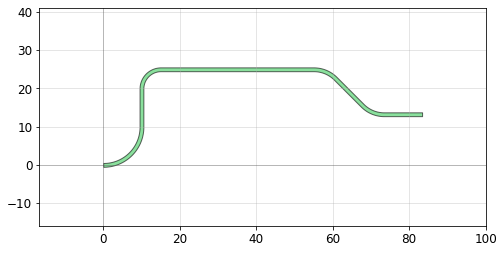

In [4]:
# Create a blank Xsection
X = Xsection()

# Add a single "section" to the cross-section
X.add(width = 1, offset = 0, layer = 0)

# Combine the Path and the Xsection
waveguide_device = P.make(xsection = X)

# Quickplot the resulting Device
qp(waveguide_device)

Now, what if we want a more complicated waveguide?  For instance, in some photonic applications it's helpful to have a shallow etch that appears on either side of the waveguide (often called a "sleeve).  Additionally, it might be nice to have a Port on either end so we can snap other geometries to it.  Let's try adding something like that in:

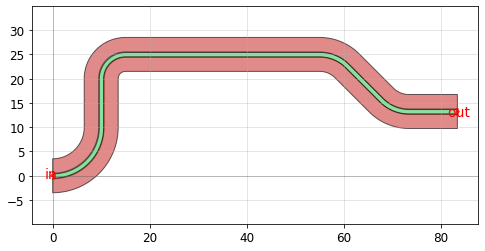

In [5]:
# Create a blank Xsection
X = Xsection()

# Add a single "section" to the cross-section
X.add(width = 1, offset = 0, layer = 0, portnames = ('in','out'))
X.add(width = 3, offset = 2, layer = 2)
X.add(width = 3, offset = -2, layer = 2)

# Combine the Path and the Xsection
waveguide_device = P.make(xsection = X)

# Quickplot the resulting Device
qp(waveguide_device)

## Custom curves

Now let's have some fun and try to make a loop-de-loop structure with parallel waveguides and several Ports. 

To create a new type of curve we simply make a function that produces an array of points.  The best way to do that is to create a function which allows you to specify a large number of points along that curve -- in the case below, the `looploop()` function outputs 1000 points along a looping path.  Later, if we want reduce the number of points in our geometry we can trivially `simplify` the path.

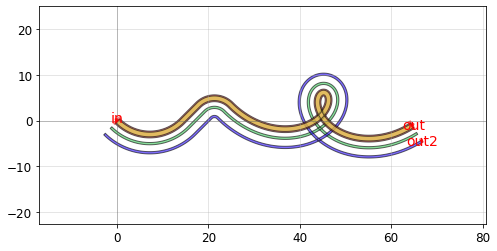

In [6]:
def looploop(num_pts = 1000):
    """ Simple limacon looping curve """
    t = np.linspace(-np.pi,0,num_pts)
    r = 20 + 25*np.sin(t)
    x = r*np.cos(t)
    y = r*np.sin(t)
    points = np.array((x,y)).T
    return points

# Create the path points
P = Path(start_angle = -45)  # Start out with a path at -45 degrees
P.append( pp.arc(radius = 10, angle = 90) )
P.append( pp.straight())
P.append( pp.arc(radius = 5, angle = -90) )
P.append( looploop(num_pts = 1000) )

# Create the crosssection
X = Xsection()
X.add(width = 0.5, offset = 2, layer = 0, portnames = [None,None])
X.add(width = 0.5, offset = 4, layer = 1, portnames = [None,'out2'])
X.add(width = 1.5, offset = 0, layer = 2, portnames = ['in','out'])
X.add(width = 1, offset = 0, layer = 3)

D = P.make(xsection = X)
qp(D) # quickplot the resulting Device

## Simplifying / reducing point usage

One of the chief concerns of generating smooth curves is that too many points are generated, inflating file sizes and making boolean operations computationally expensive.  Fortunately, PHIDL has a fast implementation of the [Ramer-Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) that lets you reduce the number of points in a curve without changing its shape.  All that needs to be done is when you `make()` the device, you specify the `simplify` argument.

If we specify `simplify = 1e-3`, the number of points in the line drops from 12,000 to 4,000, and the remaining points form a line that is identical to within `1e-3` distance from the original:

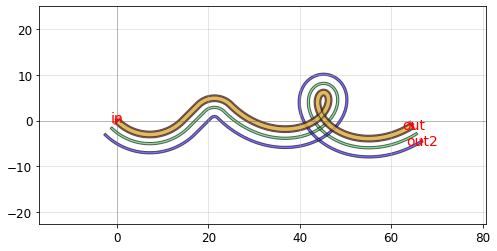

In [7]:
# The remaining points form a identical line to within `1e-3` from the original
D = P.make(xsection = X, simplify = 1e-3)
qp(D) # quickplot the resulting Device

Let's say we need fewer points.  We can increase the simplify tolerance by specifying `simplify = 1e-1`.  This drops the number of points to ~400 points form a line that is identical to within `1e-1` distance from the original:

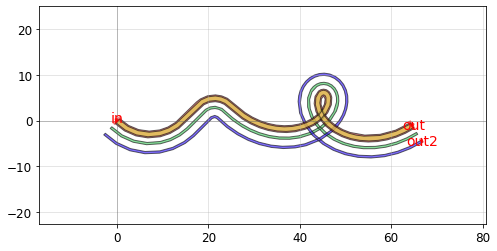

In [8]:
D = P.make(xsection = X, simplify = 1e-1)
qp(D) # quickplot the resulting Device

Taken to absurdity, what happens if we set `simplify = 0.3`?  Once again, the ~200 remaining points form a line that is within `0.3` units from the original -- but that line looks pretty bad.  

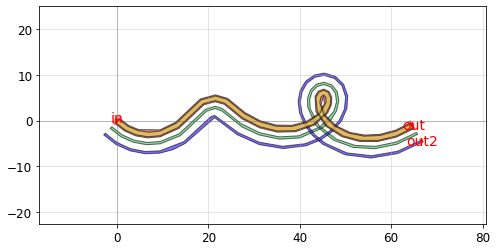

In [9]:
D = P.make(xsection = X, simplify = 0.3)
qp(D) # quickplot the resulting Device

## Curvature calculation

The `Path` class has a `curvature()` method that computes the curvature of your path.  This can be helpful for guaranteeing your curves transition smoothly such as in [track-transition curves](https://en.wikipedia.org/wiki/Track_transition_curve) (also known as clothoid or euler curves in the photonics world).  Note this curvature is numerically computed so it is only approximate, and areas where the curvature jumps instantaenously (such as between an arc and a straight segment) will be slightly interpolated.

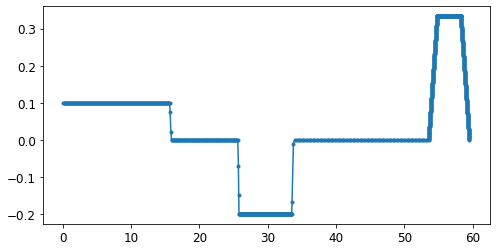

In [15]:
P = Path()
P.append( pp.arc(radius = 10, angle = 90) ) # Should have a curvature of 1/10
P.append( pp.straight(length = 10) )        # Should have a curvature of 0
P.append( pp.arc(radius = 5, angle = -90) ) # Should have a curvature of -1/5
P.append( pp.straight(length = 20) )        # Should have a curvature of 0
P.append( pp.partial_euler(angle = 90, Rmin = 3, p = 1, num_pts = 4000) )        # Should have a curvature of 0

s,K = P.curvature()
plt.plot(s,K,'.-')